<a href="https://colab.research.google.com/github/InGev007/olx_model/blob/main/OLX_dump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Модель прогнозування ціни на аренду житла у Запоріжжі

##Основні налаштування

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Парсимо данні - 1 чи працюємо з існуючим файлом - 0?
##*Парсинг данних займає приблизно 10-20 хвилин
parsing = 0
# Якщо parsing = 0 вкажіть путь до json файлу на google disk
json_file = '/content/drive/MyDrive/учёба/olx_dataset/olx_full-20-04-23 18-19.json'
# Якщо parsing = 1 вкажіть путь де знаходится існуюча БД або вона буде створена на google disk
db_patch = '/content/drive/MyDrive/учёба/olx_dataset/'

#Данні для передбачення
#['Район міста': 0-6,' Поверх': int, 'Поверховість будинку': int, 'Загальна площа': int або float, 'Площа кухні': int або float, 'Кількість кімнат': int]
#Район міста: {'Олександрiвський': 0, 'Дніпровський': 1, 'Вознесенівський': 2, 'Шевченківський': 3, 'Хортицький': 4, 'Комунарський': 5, 'Заводський': 6}
pred_data=[6, 9, 9, 33, 6, 1]

##Парсинг данних з OLX

###Функції

####Функції роботи з БД

In [ ]:
import sqlite3


# Указываем имя базы данных
db_name= db_patch+'olx.db'

if parsing == 1:
  with sqlite3.connect(db_name) as  conn:
    cur = conn.cursor()
    cur.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='apartment_rental'")
    table_exists = cur.fetchone()
    if not table_exists:
      cur.execute('''CREATE TABLE apartment_rental (
                      id INTEGER PRIMARY KEY,
                      url TEXT UNIQUE NOT NULL,
                      title TEXT NOT NULL,
                      price REAL NOT NULL,
                      city TEXT NOT NULL,
                      region TEXT NOT NULL,
                      additional_data TEXT
                  )''')
      
      
def add_data(data=dict):
  with sqlite3.connect(db_name) as  conn:
    # print(data)
    cur = conn.cursor()
    url = data['url']
    title = data['title']
    price = data['price']
    city = data['city']
    region = data['area']
    del data['url']
    del data['title']
    del data['price']
    del data['city']
    del data['area']
    additional_data = data
    
    cur.execute('''INSERT OR REPLACE INTO apartment_rental (url, title, price, city, region, additional_data) 
                    VALUES (?, ?, ?, ?, ?, ?)''', (url, title, price, city, region, str(additional_data)))

####Функції збереження данних з БД у JSON

In [ ]:
import datetime 


def save_json():
  global json_file
  x = datetime.datetime.now()
  with sqlite3.connect(db_name) as  conn:
    cur = conn.cursor()
    cur.execute("SELECT * FROM apartment_rental")
    results=cur.fetchall()
  data_to_json=[]
  for data in results:
    temp={}
    temp['url']=data[1]
    temp['title']=data[2]
    temp['price']=data[3]
    temp['city']=data[4]
    temp['area']=data[5]
    temps= eval(data[6])
    for i in temps:
      temp[i]=temps[i]
    data_to_json.append(temp)
  json_object = json.dumps(data_to_json)
  data=x.strftime("-%d-%m-%y %H-%M")
  json_file = f"{db_patch}olx_full{data}.json"
  with open(json_file, "w") as outfile:
      outfile.write(json_object)

####Функції парсера

In [ ]:
import requests
import time
import random
from bs4 import BeautifulSoup

def get_site(url, i=0):
  page = requests.get(url)
  if page.status_code == 200:
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup
  else:
    if i>10:
      raise "Error to get site"
    else:
      i+=1
      time.sleep(random.randint(5,20))
      get_site(url, i)

def parse_list(url, res, i=0):
  soup = get_site(url)
  results = soup.find_all('div', attrs={'data-cy': 'l-card'})
  res=[]
  for result in results:
    item = {}
    try:
      #url обьявления
      item['url']='https://www.olx.ua' + result.find('a')['href']
      #Тема
      item['title']=result.find('h6').text
      #Цена
      item['price']=int(result.find('p', attrs={'data-testid': 'ad-price'}).text.split(' г')[0].replace(' ', ''))
      #Локация/дата
      temp=result.find('p', attrs={'data-testid': 'location-date'}).text
      item['city']=temp.split(' -')[0].split(', ')[0]
      item['area']=temp.split(' -')[0].split(', ')[1] 
    except Exception as e:
      print(result)
      print(f'{e}-не получилось 1, попытка №{i}')
      time.sleep(random.randint(5,20))
      i+=1
      parse_list(url,res,i)
    res.append(item)
  return res

def parse_page(url, res, i=0):
  pass

###Основний цикл парсера

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import random
import json

if parsing == 1:
  num_page=1
  res = []
  while num_page<26:
    # print(num_page)
    url = f'https://www.olx.ua/d/uk/nedvizhimost/kvartiry/dolgosrochnaya-arenda-kvartir/zaporozhe/?currency=UAH&page={num_page}'
    for item in parse_list(url,res):
      res.append(item)
    # time.sleep(random.randint(0,2))
    num_page+=1

  for obj in res:
    if len(obj)==5:
      # print(obj)
      url=obj['url']
      soup = get_site(url)
      try:
        results=soup.find('ul', class_="css-sfcl1s").find_all('p')
        for result in results:
          if len(result.text.split(': '))!=1:
            obj[result.text.split(': ')[0]]=result.text.split(': ')[1]
      except Exception as e:
        print(f'{e}- не получилось 2 - {url}')
        # time.sleep(random.randint(0,2))
        continue
      # time.sleep(random.randint(0,2))

  print(res)
  for data in res:
    add_data(data)
  save_json()

##Обробка отриманих данних

###Завантаження датасету

In [ ]:
import pandas as pd

df=pd.read_json(json_file)
df.head()

,url,title,price,city,area,Тип будинку,Поверх,Поверховість,Загальна площа,Площа кухні,...,Меблювання,Побутова техніка,Мультимедіа,Комфорт,Комунікації,Інфраструктура (до 500 метрів),Планування,Ландшафт (до 1 км.),Додатково,Домашні улюбленці
0,https://www.olx.ua/d/uk/obyavlenie/arenda-1h-k...,Аренда 1х ком. кв по ул. Глиссерная (Александр...,4000,Запоріжжя,Олександрiвський,Хрущовка,1.0,5.0,30 м²,6 м²,...,З меблями,"Електрочайник, Холодильник, Праска, Мультиварк...","Швидкісний інтернет, Телевізор, Wi-Fi","Кондиціонер, Ванна, Меблі на кухні, Паркувальн...","Асфальтована дорога, Центральна каналізація, Е...","Відділення банку, банкомат, Аптека, Лікарня, п...",NaN,NaN,NaN,NaN
1,https://www.olx.ua/d/uk/obyavlenie/mozhno-zaez...,"Можно заезжать! 3-комн квартира в ЖК ,,Ренесса...",19500,Запоріжжя,Дніпровський,Царський будинок,1.0,4.0,82 м²,6 м²,...,З меблями,"Посудомийна машина, Холодильник, Духова шафа, ...","Телевізор, Wi-Fi","Кондиціонер, Балкон, лоджія, Ванна, Підігрів п...","Асфальтована дорога, Центральна каналізація, Е...","Парк, зелена зона, Ресторан, кафе, Магазин, кі...",Студія,NaN,NaN,NaN
2,https://www.olx.ua/d/uk/obyavlenie/sdaetsya-kv...,Сдается квартира! Люкс!,12000,Запоріжжя,Олександрiвський,Царський будинок,1.0,2.0,58 м²,7 м²,...,З меблями,"Посудомийна машина, Електрочайник, Холодильник...","Телевізор, Wi-Fi","Кондиціонер, Ванна, Підігрів підлоги, Меблі на...","Асфальтована дорога, Центральна каналізація, Е...","Магазин, кіоск, Супермаркет, ТРЦ, Зупинка тран...",Студія,Парк,Тільки сім'ям,NaN
3,https://www.olx.ua/d/uk/obyavlenie/svobodnaya-...,Свободная! 2-ком. квартира + гараж на Набережной!,6500,Запоріжжя,Олександрiвський,Чешка,4.0,9.0,52 м²,9 м²,...,З меблями,"Холодильник, Плита, Пральна машина",NaN,"Балкон, лоджія, Ванна, Ліфт, Меблі на кухні","Центральна каналізація, Електрика, Газ, Центра...","Відділення банку, банкомат, Аптека, Парк, зеле...","Суміжна, прохідна",Парк,NaN,Ні 🥺
4,https://www.olx.ua/d/uk/obyavlenie/8000-grn-sd...,8000 грн Сдам 2 ком квартиру ул Фортечная с те...,8000,Запоріжжя,Олександрiвський,Чешка,6.0,9.0,50 м²,8 м²,...,З меблями,"Холодильник, Плита, Пральна машина",NaN,"Балкон, лоджія, Ванна, Ліфт","Електрика, Газ","Центр міста, Аптека, Ринок, Парк, зелена зона,...",Роздільна,NaN,Можна з дітьми,NaN


###Аналіз кількості та типів данних у датасеті

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             2318 non-null   object 
 1   title                           2318 non-null   object 
 2   price                           2318 non-null   int64  
 3   city                            2318 non-null   object 
 4   area                            2318 non-null   object 
 5   Тип будинку                     1329 non-null   object 
 6   Поверх                          2311 non-null   float64
 7   Поверховість                    2311 non-null   float64
 8   Загальна площа                  2311 non-null   object 
 9   Площа кухні                     2311 non-null   object 
 10  Тип стін                        1347 non-null   object 
 11  Кількість кімнат                2311 non-null   object 
 12  Cанвузол                        16

###Аналіз розподілу ціни

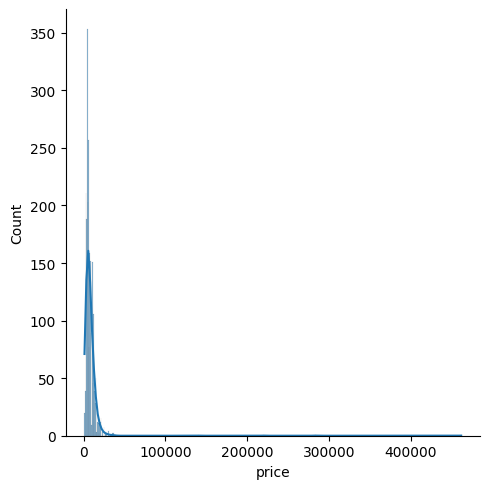

In [ ]:
import seaborn as sns

sns.displot(df, x='price', kde=True)

####Нормалізація ціни

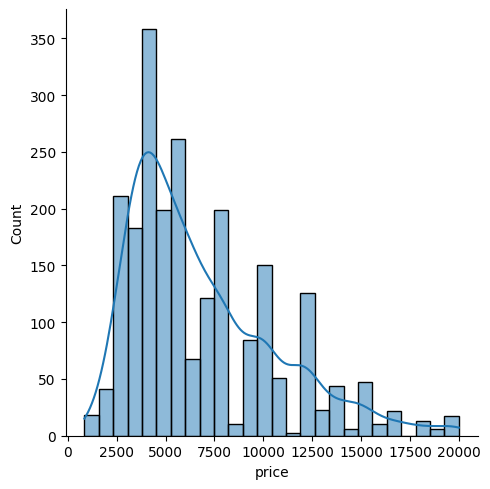

In [ ]:
df = df.loc[(df['price'] <= 20000)]
sns.displot(df, x='price', kde=True)

###Приведення данних до числових

####Основні данні

In [ ]:
#Так як кількість кімнат освновополагаючі данні видаляємо строки де вони відсутні
df = df.dropna(subset ='Кількість кімнат')
#Обрізаємо числові данні та перетворюємо у числові
df['Кількість кімнат'] = df['Кількість кімнат'].str.split(' к').str[0]
df['Кількість кімнат'] = df['Кількість кімнат'].str.split('+').str[0]
df['Кількість кімнат'] = df['Кількість кімнат'].astype(int)
df['Кількість кімнат'].unique()

<ipython-input-91-b7ec566a54b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Кількість кімнат'] = df['Кількість кімнат'].str.split(' к').str[0]
<ipython-input-91-b7ec566a54b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Кількість кімнат'] = df['Кількість кімнат'].str.split('+').str[0]
<ipython-input-91-b7ec566a54b0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

array([1, 3, 2, 4, 5])

In [ ]:
#Поверх та поверховість перетворюємо в int
df['Поверх'] = df['Поверх'].astype(int)
df['Поверховість'] = df['Поверховість'].astype(int)

<ipython-input-92-c36d953a52b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Поверх'] = df['Поверх'].astype(int)
<ipython-input-92-c36d953a52b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Поверховість'] = df['Поверховість'].astype(int)


In [ ]:
#Замінюємо райони на числові значення та створюємо словник для подальшого використання
my_ar = {'Олександрiвський': 0, 'Дніпровський': 1, 'Вознесенівський': 2, 'Шевченківський': 3, 'Хортицький': 4, 'Комунарський': 5, 'Заводський': 6}
for ar in df['area'].unique():
  if ar in my_ar:
    df = df.replace(ar, my_ar[ar])
  else:
    df = df.replace(ar, 7)
df['area'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
#заменяем 'Загальна площа' на числовое значение
df['Загальна площа'] = df['Загальна площа'].str.split(' м').str[0]
df['Загальна площа'] = df['Загальна площа'].astype(float)
# df['Загальна площа'] = df['Загальна площа'].fillna(df['Загальна площа'].mean())
print(df['Загальна площа'].unique())

[ 30.    82.    58.    52.    50.    69.    45.    15.    63.    38.
  33.    55.    57.    47.    65.    90.    87.    28.    20.    35.
  40.    42.    41.    34.    70.    67.    56.    78.    32.    62.
  85.    68.    46.    43.    25.    54.    64.    48.    22.    27.52
  53.    31.    59.    51.    36.    44.   100.    74.   103.    49.
  80.    37.    18.    60.    29.   150.   240.    72.    83.    98.
  27.    24.    39.    91.    66.    24.5  120.    93.    77.    47.7
  76.   158.    37.4   75.   156.    79.    71.    95.     4.1   86.
  33.14 105.    17.    31.73  16.   151.   110.    10.    26.    97.
  73.    21.    61.    33.93  35.2   26.75  36.7   54.3 ]


In [ ]:
#заменяем 'Площа кухні' на числовое значение

df['Площа кухні'] = df['Площа кухні'].str.split(' м').str[0]
df['Площа кухні'] = df['Площа кухні'].astype(float)
# df['Площа кухні'] = df['Площа кухні'].fillna(df['Площа кухні'].mean())
print(df['Площа кухні'].unique())

[ 6.    7.    9.    8.   12.5  10.   12.   15.   32.    4.   11.   16.
  5.   25.    6.63 30.   17.    9.5   3.    8.4  28.   14.    1.   20.
 50.   23.    6.5   4.5  13.    8.5  18.   46.   35.    2.   19.    7.8
 22.    7.5   6.8   8.8   5.9  68.    8.2  29.    6.7  24.    6.6 ]


####Додаткові данні

In [ ]:
print(df['Меблювання'].unique())
df['Меблювання'] = df['Меблювання'].str.lower().str.contains('з меблями')
df['Меблювання'] = df['Меблювання'].fillna(0)
df['Меблювання'] = df['Меблювання'].astype(int)
print(df['Меблювання'].unique())

['З меблями' nan 'Без меблів']
[1 0]


In [ ]:
df['Cанвузол'] = df['Cанвузол'].fillna(1)
df['Cанвузол'] = df['Cанвузол'].replace('Суміжний', 1)
df['Cанвузол'] = df['Cанвузол'].replace('Роздільний', 1)
df['Cанвузол'] = df['Cанвузол'].replace('2 і більше', 2)
df['Cанвузол'] = df['Cанвузол'].replace('Санвузол відсутній', 0)
df['Cанвузол'] = df['Cанвузол'].astype(int)
print(df['Cанвузол'].unique())

[1 2 0]


In [ ]:
df['Домашні улюбленці'] = df['Домашні улюбленці'].str.lower().str.contains('так')
df['Домашні улюбленці'] = df['Домашні улюбленці'].fillna(0)
df['Домашні улюбленці'] = df['Домашні улюбленці'].astype(int)
print(df['Домашні улюбленці'].unique())

[0 1]


In [ ]:
df['Ландшафт (до 1 км.)'] = df['Ландшафт (до 1 км.)'].fillna(0)
df['Ландшафт (до 1 км.)'] = df['Ландшафт (до 1 км.)'].astype(str)
df['Ландшафт (до 1 км.)'] = df['Ландшафт (до 1 км.)'].str.split(', ').str.len()-1
df['Ландшафт (до 1 км.)'] = df['Ландшафт (до 1 км.)'].astype(int)
print(df['Ландшафт (до 1 км.)'].unique())

[0 1 2 5 3]


In [ ]:
df['Інфраструктура (до 500 метрів)'] = df['Інфраструктура (до 500 метрів)'].fillna(0)
df['Інфраструктура (до 500 метрів)'] = df['Інфраструктура (до 500 метрів)'].astype(str)
df['Інфраструктура (до 500 метрів)'] = df['Інфраструктура (до 500 метрів)'].str.split(', ').str.len()-1
df['Інфраструктура (до 500 метрів)'] = df['Інфраструктура (до 500 метрів)'].astype(int)
print(df['Інфраструктура (до 500 метрів)'].unique())

[13  6 19  7  9  0 14 15 11  3 12 10  8 16 20 21 22 17 23 18  2  1  5  4
 24]


In [ ]:
df['Комунікації'] = df['Комунікації'].fillna(0)
df['Комунікації'] = df['Комунікації'].astype(str)
df['Комунікації'] = df['Комунікації'].str.split(', ').str.len()-1
df['Комунікації'] = df['Комунікації'].astype(int)
print(df['Комунікації'].unique())

[5 4 3 1 0 6 2 7]


In [ ]:
df['Комфорт'] = df['Комфорт'].fillna(0)
df['Комфорт'] = df['Комфорт'].astype(str)
df['Комфорт'] = df['Комфорт'].str.split(', ').str.len()-1
df['Комфорт'] = df['Комфорт'].astype(int)
print(df['Комфорт'].unique())

[ 3  8  7  4  0  1  2  5  6 10 12  9 11 13 14 15 25]


In [ ]:
df['Мультимедіа'] = df['Мультимедіа'].fillna(0)
df['Мультимедіа'] = df['Мультимедіа'].astype(str)
df['Мультимедіа'] = df['Мультимедіа'].str.split(', ').str.len()-1
df['Мультимедіа'] = df['Мультимедіа'].astype(int)
print(df['Мультимедіа'].unique())

[2 1 0 4 3 5 6]


In [ ]:
df['Побутова техніка'] = df['Побутова техніка'].fillna(0)
df['Побутова техніка'] = df['Побутова техніка'].astype(str)
df['Побутова техніка'] = df['Побутова техніка'].str.split(', ').str.len()-1
df['Побутова техніка'] = df['Побутова техніка'].astype(int)
print(df['Побутова техніка'].unique())

[ 6  4  5  2  0  8  1  3  7  9 11 13 10 14]


####Данні які важко обробити та малозаповнені данні (під видалення)

In [ ]:
print(df.isnull().sum())

url                                  0
title                                0
price                                0
city                                 0
area                                 0
Тип будинку                        960
Поверх                               0
Поверховість                         0
Загальна площа                       0
Площа кухні                          0
Тип стін                           943
Кількість кімнат                     0
Cанвузол                             0
Опалення                           825
Ремонт                             802
Меблювання                           0
Побутова техніка                     0
Мультимедіа                          0
Комфорт                              0
Комунікації                          0
Інфраструктура (до 500 метрів)       0
Планування                         899
Ландшафт (до 1 км.)                  0
Додатково                         1867
Домашні улюбленці                    0
dtype: int64


In [ ]:
print(df['Тип будинку'].unique())
print(df['Тип стін'].unique())
print(df['Планування'].unique())
print(df['Опалення'].unique()) # Я думаю удалить
print(df['Ремонт'].unique())
print(df['Додатково'].unique())

['Хрущовка' 'Царський будинок' 'Чешка' nan 'Сталінка' 'Гостинка'
 'Житловий фонд від 2011 р.' 'Житловий фонд 80-90-і'
 'Житловий фонд 2001-2010-і' 'Житловий фонд 91-2000-і' 'Гуртожиток'
 'Совмін']
['Панельний' 'Цегляний' nan 'Шлакоблочний' 'Монолітний' 'Газоблок'
 "Дерев'яний" 'Інше']
[nan 'Студія' 'Суміжна, прохідна' 'Роздільна' 'Вільне планування'
 'Малосімейка, гостинка' 'Двостороння' 'Смарт-квартира' 'Пентхаус']
['Централізоване' 'Індивідуальне газове' 'Індивідуальне електро' nan
 'Власна котельня' 'Інше' 'Комбіноване' 'Твердопаливне' 'Тепловий насос']
['Євроремонт' 'Авторський проект' 'Житловий стан' 'Косметичний ремонт' nan
 'Під чистову обробку' 'Аварійний стан']
[nan "Тільки сім'ям" 'Можна з дітьми' "Тільки сім'ям, Можна з дітьми"
 'Можна іноземцям'
 'Можна іноземцям, Можна курити, Можна студентам, Можна з дітьми, З господарями'
 "Можна іноземцям, Тільки сім'ям, Можна студентам, Можна з дітьми"
 "Тільки сім'ям, Можна студентам, Можна з дітьми" 'Можна студентам'
 "Можна іноземця

In [ ]:
df=df.drop(columns=['url', 'city', 'Тип будинку', 'Тип стін', 'Планування', 'Опалення', 'Ремонт', 'Додатково'])

##Створення та навчання моделей

###Розбиття данних на вибірки

In [ ]:
from sklearn.model_selection import train_test_split
# Выделите целевую переменную (цену) и признаки (все остальные столбцы)
X = df.drop(['price', 'title', 'Cанвузол', 'Меблювання', 'Побутова техніка', 'Мультимедіа', 'Комфорт', 'Комунікації', 'Інфраструктура (до 500 метрів)', 'Ландшафт (до 1 км.)', 'Домашні улюбленці'], axis=1)
y = df['price']
# Разбейте данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2263 entries, 0 to 2317
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   area              2263 non-null   int64  
 1   Поверх            2263 non-null   int64  
 2   Поверховість      2263 non-null   int64  
 3   Загальна площа    2263 non-null   float64
 4   Площа кухні       2263 non-null   float64
 5   Кількість кімнат  2263 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 123.8 KB


###Працюючі моделі

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

# Создание модели градиентного бустинга
gbr = GradientBoostingRegressor(n_estimators=550, learning_rate=0.2, max_depth=5, random_state=42)
gbr.fit(X_train, y_train)

# Предсказание цен на тестовых данных
y_pred = gbr.predict(X_test)

gbr_score={}
gbr_score['R2'] = r2_score(y_test, y_pred)
# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.8210847086358923
MAE: 886.9204446354644
RMSE: 1539.9894882910164


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

# Создание и обучение модели
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Прогнозирование цен на тестовом наборе данных
y_pred = rf.predict(X_test)

rf_score={}
rf_score['R2'] = r2_score(y_test, y_pred)
# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.8125298203489723
MAE: 1011.4028541868361
RMSE: 1576.3771252065517


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

# Обучаем модель на обучающей выборке
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)

# Предсказываем значения для тестовой выборки
y_pred = dtr.predict(X_test)

dtr_score={}
dtr_score['R2'] = r2_score(y_test, y_pred)
# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score: 0.7620800408893398
MAE: 825.9243053365569
RMSE: 1775.8630239266677


###Моделі з еффективністю менше 70%

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Создайте объект модели линейной регрессии и обучите его на обучающих данных
lr = LinearRegression()
lr.fit(X_train, y_train)

# Прогнозируем значения на тестовой выборке
y_pred = lr.predict(X_test)

# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.38738716003829166
MAE: 2207.513242147796
MSE: 8120338.771781614


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели множественной линейной регрессии
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Сделать прогноз на тестовом наборе
y_pred = lin_reg.predict(X_test_scaled)

# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.38738716003829166
MAE: 2207.5132421477965
MSE: 8120338.771781613


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение SVM модели
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train)

# Сделать прогноз на тестовом наборе
y_pred = svr.predict(X_test_scaled)

# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.25680778308132746
MAE: 2369.0487321701185
MSE: 9851201.575057171


In [ ]:
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

krr = KernelRidge(alpha=0.1)
krr.fit(X_train, y_train)

# Сделать прогноз на тестовом наборе
y_pred = krr.predict(X_test)

# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.3862221718099176
MAE: 2145.1544172407166
MSE: 8135780.9866070915


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

bclf = BaggingClassifier(estimator=SVC(),n_estimators=100, random_state=0).fit(X_train, y_train)

# Сделать прогноз на тестовом наборе
y_pred = bclf.predict(X_test)

# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.18646634964278863
MAE: 2370.551876379691
MSE: 10783595.139072848


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)

# Сделать прогноз на тестовом наборе
y_pred = gpr.predict(X_test)

# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.348024432480896
MAE: 2292.8538754650826
MSE: 8642101.722044583


In [ ]:
from sklearn.neural_network import MLPClassifier

y_pred = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(12, 4), random_state=1).fit(X_train, y_train).predict(X_test)

# Оценка качества модели
print("R2 score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 score: 0.3400723136041053
MAE: 2232.5121412803533
MSE: 8747509.077262694


##Передбачення за допомогою моделі

In [ ]:
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)


data = np.array(pred_data).reshape(1, -1)
# data = {'area': 6,' Поверх': 5, 'Поверховість': 9, 'Загальна площа': 35, 'Площа кухні':9, 'Кількість кімнат': 1}.reshape(-1,1)
if (gbr_score['R2'] > rf_score['R2']) and (gbr_score['R2'] > dtr_score['R2']):
  print("Найкраща модель передбачення GradientBoostingRegressor")
  print(f"Передбачена моделлю ціна - {gbr.predict(data)[0].round(1)}")
if (rf_score['R2'] > gbr_score['R2']) and (rf_score['R2'] > dtr_score['R2']):
  print("Найкраща модель передбачення RandomForestRegressor")
  print(f"Передбачена моделлю ціна - {rf.predict(data)[0].round(1)}")
if (dtr_score['R2'] > gbr_score['R2']) and (dtr_score['R2'] > rf_score['R2']):
  print("Найкраща модель передбачення DecisionTreeRegressor")
  print(f"Передбачена моделлю ціна - {dtr.predict(data)[0].round(1)}")

Найкраща модель передбачення GradientBoostingRegressor
Передбачена моделлю ціна - 3372.2
